In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-08 15:41:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.199.64, 52.216.54.112, 52.216.176.205, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.199.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.5MB/s    in 1.0s    

2024-04-08 15:41:57 (13.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
#Paring the data-converting the comma-seperated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

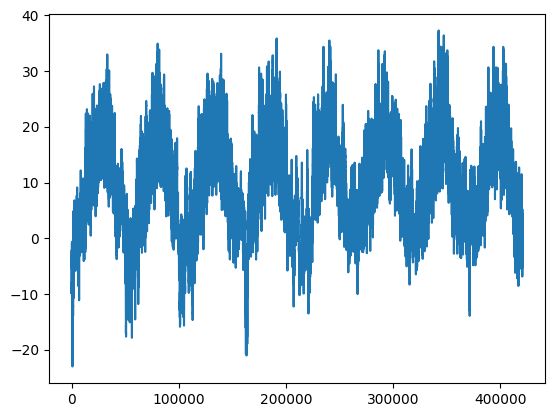

In [4]:

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

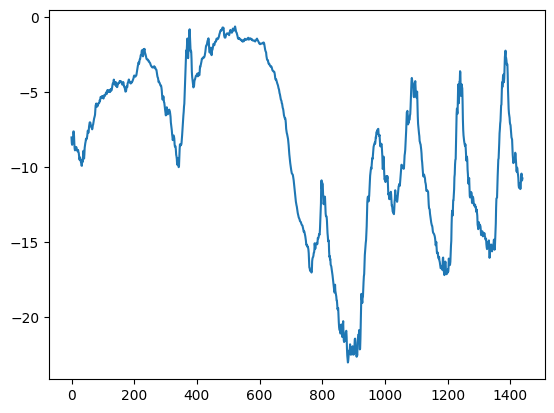

In [5]:

plt.plot(range(1440), temperature[:1440])

In [6]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
#Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly.Instead, we will generate the samples dynamically.
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
#Inspecting the output of one of our datasets
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

#A sensible baseline approach would be to forecast that the temperature in the next 24 hours will be the same as it is now. The validation MAE (Mean Absolute Error) using the simple baseline is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. Put another way, an average deviation of roughly 2.5 degrees would arise from assuming that the future temperature stays constant with the current temperature.

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
#A basic machine-learning model - Dense Layer
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 14ms/step - loss: 12.3841 - mae: 2.7205 - val_loss: 10.1999 - val_mae: 2.5220
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 8.9326 - mae: 2.3526 - val_loss: 10.5684 - val_mae: 2.5706
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 8.2562 - mae: 2.2598 - val_loss: 14.5326 - val_mae: 3.0428
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 7.8200 - mae: 2.2013 - val_loss: 10.4065 - val_mae: 2.5491
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 7.5200 - mae: 2.1579 - val_loss: 10.7224 - val_mae: 2.5901
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.2629 - mae: 2.1209 - val_loss: 11.5541 - val_mae: 2.6829
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 7.0795 - mae: 2.0951 - val_loss: 11.8307 - val_mae: 2.7227
Epoch 8/10
819/819 [==============================] - 

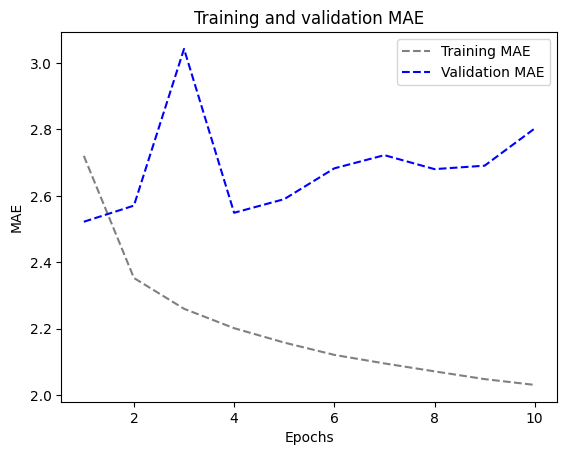

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [14]:
 #1D Convolutional Model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 14s 14ms/step - loss: 22.6866 - mae: 3.7444 - val_loss: 21.2252 - val_mae: 3.6093
Epoch 2/5
819/819 [==============================] - 13s 15ms/step - loss: 16.0628 - mae: 3.1880 - val_loss: 16.9898 - val_mae: 3.2566
Epoch 3/5
819/819 [==============================] - 12s 14ms/step - loss: 14.2237 - mae: 2.9943 - val_loss: 16.0588 - val_mae: 3.1471
Epoch 4/5
819/819 [==============================] - 11s 14ms/step - loss: 13.4021 - mae: 2.9041 - val_loss: 16.8554 - val_mae: 3.2466
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 16.5658 - mae: 3.2254
Test MAE: 3.23


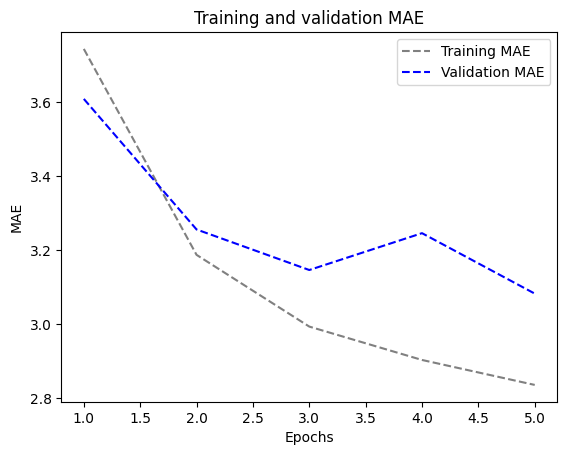

In [15]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [16]:
#Understanding recurrent neural networks
#NumPy implementation of a simple RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [17]:
#A recurrent layer in Keras
#An RNN layer that can process sequences of any length

num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [18]:
#RNN

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 12s 14ms/step - loss: 12.3088 - mae: 2.7801 - val_loss: 14.9987 - val_mae: 3.0433
Epoch 2/5
819/819 [==============================] - 11s 14ms/step - loss: 11.8314 - mae: 2.7222 - val_loss: 14.3994 - val_mae: 2.9855
Epoch 3/5
819/819 [==============================] - 12s 14ms/step - loss: 11.4390 - mae: 2.6771 - val_loss: 15.5474 - val_mae: 3.0955
Epoch 4/5
819/819 [==============================] - 11s 14ms/step - loss: 11.0614 - mae: 2.6355 - val_loss: 14.9511 - val_mae: 3.0586
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 15.9004 - mae: 3.1290
Test MAE: 3.13


In [19]:
#Simple RNN with stacked layer
from tensorflow import keras
from tensorflow.keras import layers
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 185s 223ms/step - loss: 136.9514 - mae: 9.5703 - val_loss: 143.4285 - val_mae: 9.8396
Epoch 2/5
819/819 [==============================] - 184s 224ms/step - loss: 135.9355 - mae: 9.5125 - val_loss: 143.5001 - val_mae: 9.8499
Epoch 3/5
819/819 [==============================] - 183s 224ms/step - loss: 135.8966 - mae: 9.5069 - val_loss: 143.3827 - val_mae: 9.8345
Epoch 4/5
819/819 [==============================] - 184s 224ms/step - loss: 135.8732 - mae: 9.5027 - val_loss: 143.3994 - val_mae: 9.8380
Epoch 5/5
405/405 [==============================] - 14s 32ms/step - loss: 151.0841 - mae: 9.8991
Test MAE: 9.90


In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked_1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked_1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 192s 232ms/step - loss: 136.4822 - mae: 9.5506 - val_loss: 143.4646 - val_mae: 9.8401
Epoch 2/5
819/819 [==============================] - 194s 236ms/step - loss: 135.9306 - mae: 9.5119 - val_loss: 143.4414 - val_mae: 9.8383
Epoch 3/5
819/819 [==============================] - 190s 232ms/step - loss: 135.8829 - mae: 9.5047 - val_loss: 143.3940 - val_mae: 9.8312
Epoch 4/5
819/819 [==============================] - 190s 231ms/step - loss: 135.8304 - mae: 9.4969 - val_loss: 143.4512 - val_mae: 9.8381
Epoch 5/5
405/405 [==============================] - 14s 32ms/step - loss: 151.2064 - mae: 9.9132
Test MAE: 9.91


In [21]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# GRU layer
x = layers.GRU(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 15s 16ms/step - loss: 38.3601 - mae: 4.4984 - val_loss: 12.6437 - val_mae: 2.6856
Epoch 2/5
819/819 [==============================] - 12s 15ms/step - loss: 10.5992 - mae: 2.5339 - val_loss: 9.6861 - val_mae: 2.4049
Epoch 3/5
819/819 [==============================] - 12s 15ms/step - loss: 9.5800 - mae: 2.4202 - val_loss: 9.5769 - val_mae: 2.3897
Epoch 4/5
819/819 [==============================] - 12s 15ms/step - loss: 9.1725 - mae: 2.3640 - val_loss: 9.2723 - val_mae: 2.3571
Epoch 5/5
405/405 [==============================] - 5s 9ms/step - loss: 9.8280 - mae: 2.4597
Test MAE: 2.46


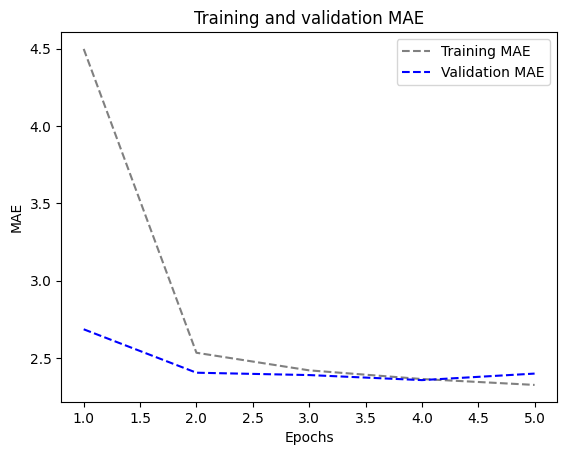

In [22]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [23]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 14s 16ms/step - loss: 41.1510 - mae: 4.6785 - val_loss: 12.5605 - val_mae: 2.7054
Epoch 2/5
819/819 [==============================] - 12s 15ms/step - loss: 10.8931 - mae: 2.5608 - val_loss: 10.5746 - val_mae: 2.4770
Epoch 3/5
819/819 [==============================] - 12s 15ms/step - loss: 9.6295 - mae: 2.4164 - val_loss: 10.2615 - val_mae: 2.4576
Epoch 4/5
819/819 [==============================] - 13s 15ms/step - loss: 9.1497 - mae: 2.3535 - val_loss: 9.7226 - val_mae: 2.4226
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 10.4552 - mae: 2.5435
Test MAE: 2.54


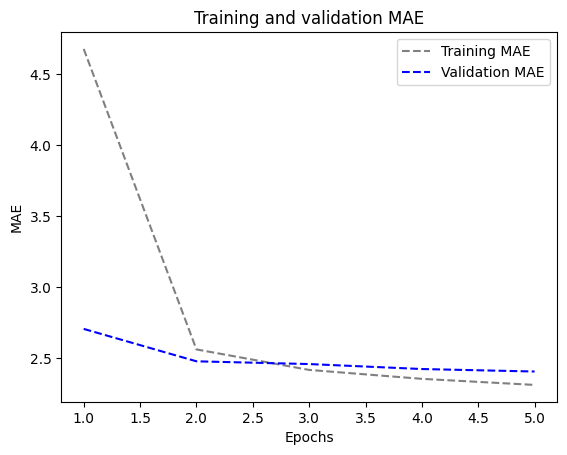

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(16)(inputs)
#Dropout layer
x = layers.Dropout(0.5)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 15s 15ms/step - loss: 46.2360 - mae: 5.0710 - val_loss: 13.2310 - val_mae: 2.7531
Epoch 2/5
819/819 [==============================] - 12s 15ms/step - loss: 19.8553 - mae: 3.4227 - val_loss: 10.0303 - val_mae: 2.4535
Epoch 3/5
819/819 [==============================] - 13s 15ms/step - loss: 17.9661 - mae: 3.2598 - val_loss: 9.5451 - val_mae: 2.3963
Epoch 4/5
638/819 [======================>.......] - ETA: 1s - loss: 17.1619 - mae: 3.1875

In [26]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM stacked layer
x = layers.LSTM(16,return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_1.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 18s 19ms/step - loss: 35.0325 - mae: 4.2833 - val_loss: 11.3649 - val_mae: 2.5724
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 10.0366 - mae: 2.4571 - val_loss: 9.3852 - val_mae: 2.3934
Epoch 3/5
819/819 [==============================] - 15s 18ms/step - loss: 8.7596 - mae: 2.3088 - val_loss: 9.8769 - val_mae: 2.4503
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 8.0782 - mae: 2.2201 - val_loss: 9.9826 - val_mae: 2.4826
Epoch 5/5
405/405 [==============================] - 6s 11ms/step - loss: 11.4039 - mae: 2.6455
Test MAE: 2.65


In [27]:
from tensorflow import keras
from tensorflow.keras import layers
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(32,return_sequences=True)(inputs)
#LSTM Stacked layer
x = layers.LSTM(32)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_2.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 18s 19ms/step - loss: 20.6202 - mae: 3.2478 - val_loss: 10.9955 - val_mae: 2.6025
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 7.5000 - mae: 2.1252 - val_loss: 10.8575 - val_mae: 2.5967
Epoch 3/5
819/819 [==============================] - 15s 18ms/step - loss: 5.8484 - mae: 1.8770 - val_loss: 11.5063 - val_mae: 2.6894
Epoch 4/5
819/819 [==============================] - 15s 19ms/step - loss: 4.7879 - mae: 1.6969 - val_loss: 11.8688 - val_mae: 2.7292
Epoch 5/5
405/405 [==============================] - 6s 11ms/step - loss: 11.8676 - mae: 2.7008
Test MAE: 2.70


In [28]:
#input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(8,return_sequences=True)(inputs)
#LSTM Stacked layer
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_3.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 18s 19ms/step - loss: 75.2523 - mae: 6.6756 - val_loss: 38.0641 - val_mae: 4.6125
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 22.8618 - mae: 3.5387 - val_loss: 13.6216 - val_mae: 2.7668
Epoch 3/5
819/819 [==============================] - 15s 18ms/step - loss: 11.5512 - mae: 2.6297 - val_loss: 9.9590 - val_mae: 2.4547
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 10.0319 - mae: 2.4727 - val_loss: 9.5898 - val_mae: 2.4080
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 11.0990 - mae: 2.6122
Test MAE: 2.61


In [29]:
from tensorflow import keras
from tensorflow.keras import layers

# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# stacked layers
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 19s 19ms/step - loss: 66.7343 - mae: 6.1990 - val_loss: 34.5443 - val_mae: 4.3142
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 20.3417 - mae: 3.3021 - val_loss: 13.0119 - val_mae: 2.7160
Epoch 3/5
819/819 [==============================] - 15s 18ms/step - loss: 10.3547 - mae: 2.4820 - val_loss: 10.2807 - val_mae: 2.4998
Epoch 4/5
819/819 [==============================] - 15s 19ms/step - loss: 8.9929 - mae: 2.3291 - val_loss: 10.1084 - val_mae: 2.4918
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 11.1820 - mae: 2.6174
Test MAE: 2.62


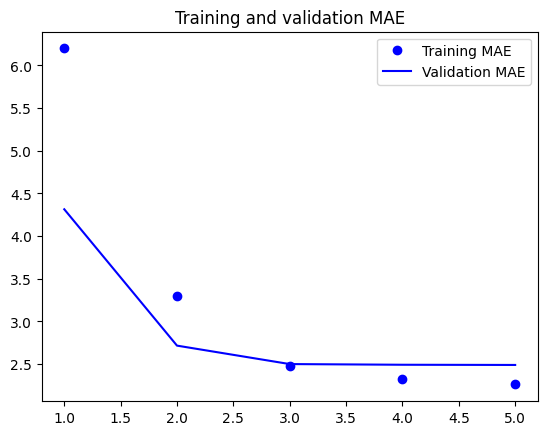

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [37]:
#lstm droput
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 428s 517ms/step - loss: 75.2676 - mae: 6.6756 - val_loss: 35.7708 - val_mae: 4.4319
Epoch 2/5
819/819 [==============================] - 417s 509ms/step - loss: 32.0573 - mae: 4.2280 - val_loss: 14.1469 - val_mae: 2.8026
Epoch 3/5
819/819 [==============================] - 424s 518ms/step - loss: 24.6182 - mae: 3.7520 - val_loss: 11.2591 - val_mae: 2.5638
Epoch 4/5
819/819 [==============================] - 421s 515ms/step - loss: 22.6133 - mae: 3.6068 - val_loss: 10.0663 - val_mae: 2.4446
Epoch 5/5
819/819 [==============================] - 427s 521ms/step - loss: 21.2667 - mae: 3.5037 - val_loss: 9.7392 - val_mae: 2.4228


405/405 [==============================] - 29s 71ms/step - loss: 11.2645 - mae: 2.5997
Test MAE: 2.60


In [32]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
819/819 [==============================] - 18s 19ms/step - loss: 27.2690 - mae: 3.7465 - val_loss: 11.9416 - val_mae: 2.6648
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 9.7948 - mae: 2.4284 - val_loss: 10.4043 - val_mae: 2.5033
Epoch 3/5
819/819 [==============================] - 15s 19ms/step - loss: 8.7588 - mae: 2.2996 - val_loss: 10.0149 - val_mae: 2.4485
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 8.1332 - mae: 2.2220 - val_loss: 9.9850 - val_mae: 2.4534
Epoch 5/5
819/819 [==============================] - 15s 18ms/step - loss: 7.7168 - mae: 2.1624 - val_loss: 10.2632 - val_mae: 2.4834


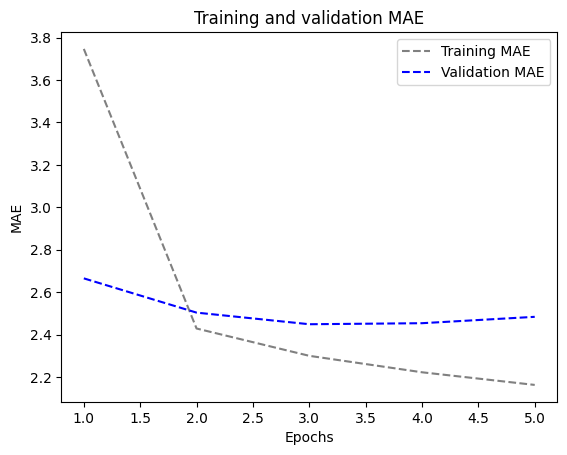

In [34]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [35]:
#1D convents and LSTM together
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 15s 15ms/step - loss: 45.0058 - mae: 5.0149 - val_loss: 24.2782 - val_mae: 3.8532
Epoch 2/5
819/819 [==============================] - 12s 15ms/step - loss: 17.1456 - mae: 3.2024 - val_loss: 22.2640 - val_mae: 3.7988
Epoch 3/5
819/819 [==============================] - 12s 15ms/step - loss: 14.1831 - mae: 2.9269 - val_loss: 22.5809 - val_mae: 3.7480
Epoch 4/5
819/819 [==============================] - 12s 15ms/step - loss: 12.6669 - mae: 2.7617 - val_loss: 20.6683 - val_mae: 3.6276
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 23.5906 - mae: 3.8770
Test MAE: 3.88


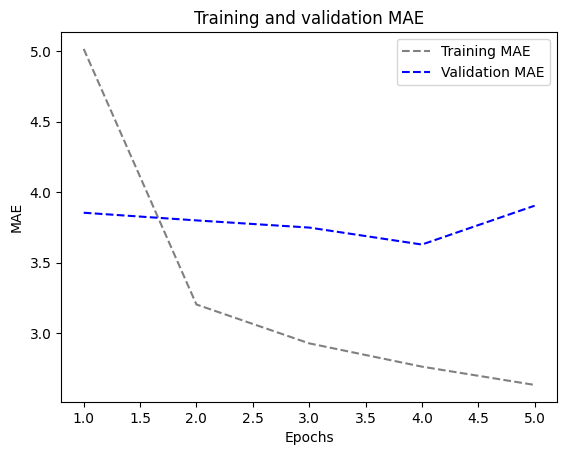

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()